<span style = "color:blue; font-size:24px">ARIMAModelFitSVMRev6</span>

This notebook only focuses on ARIMA model training.

<span style = "color:blue; font-size:24px">Preprocessing for ARIMA Model</span>

In [1]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

# Initialize Spark session
spark = SparkSession.builder.config("SPARK_LOCAL_IP", "192.168.1.2") \
                            .appName("Pre-Preprocess Mission Log") \
                            .master("spark://192.168.1.2:7077") \
                            .config("spark.driver.cores", "2") \
                            .config("spark.driver.memory", "10g") \
                            .config("spark.executor.memory", "12g") \
                            .config("spark.executor.cores", "3") \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true") \
                            .config("spark.dynamicAllocation.minExecutors", "5") \
                            .config("spark.dynamicAllocation.maxExecutors", "8") \
                            .config("spark.executor.instances", "5") \
                            .getOrCreate()

#Paths containing network data
data_paths = ["hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
            ]
# Predefined list of MITRE ATT&CK labels
mitre_labels = [
    "Privilege Escalation", "Execution", "Persistence", "Defense Evasion",
    "Credential Access", "Discovery", "Lateral Movement", "Collection",
    "Exfiltration", "Command and Control", "Impact", "Reconnaissance", "Resource Development"
]

# Container to hold the processed DataFrames
df_list = []

# Counter variable
j = 0

# Loop through each path, load and process the data
for path in data_paths:
    # Load each dataset
    df = spark.read.parquet(path)
   
    # Select relevant columns
    df = df.select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
   
    #Show all rows of attack labels before any preprocessing
    print(f"Dataset {j+1}: All rows of 'label_tactic' before preprocessing:")
    all_label_tactics = df.select("label_tactic").distinct().collect()
    for row in all_label_tactics:
        print(row['label_tactic'])
              
    # Handle missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0,
        "label_tactic": "none"  # Default to 'none'
    })

    # Print unique count for each tactic type
    print(f"Dataset {j+1}: Unique count for each 'label_tactic' value before conversion")
    unique_tactic_counts = df.groupBy("label_tactic").count().orderBy(F.desc("count"))
    unique_tactic_counts.show(truncate=False)
   
    # Convert 'label_tactic' to binary: 'none' -> 0, anything else -> 1
    df = df.withColumn("label_tactic_binary", F.when(F.col("label_tactic") == "none", 0).otherwise(1))

    # Show the first few rows after binary conversion to verify
    print(f"First few rows after binary encoding:")
    df.select("label_tactic", "label_tactic_binary").show(5, truncate=False)

    # Convert 'label_tactic' to list of attack types for encoding
    df = df.withColumn("label_tactic_split", F.split("label_tactic", ","))
   
    # Perform MultiLabel encoding (before aggregation)
    df = df.withColumn("label_tactic_binary_encoded", F.expr(
        "array(" + ",".join([f"IF(array_contains(label_tactic_split, '{label}'), 1, 0)" for label in mitre_labels]) + ")"
    ))

    # Show the first few rows of 'label_tactic_binary_encoded' to check encoding
    print(f"First few rows of 'label_tactic_binary_encoded' (encoded attack types):")
    df.select("label_tactic", "label_tactic_split", "label_tactic_binary_encoded").show(5, truncate=False)

    #Time window 
    # Convert 'ts' to a timestamp
    df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
   
    # Aggregate data within time windows
    window_size = "1 seconds"
    stride = "0 minutes"  # Remove overlap
    
    df_agg = df.groupBy(F.window("ts", window_size)) \
        .agg(
            F.sum("orig_bytes").alias("sum_orig_bytes"),
            F.sum("resp_bytes").alias("sum_resp_bytes"),
            F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
            F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
            F.count("*").alias("connection_count"),
            F.max("label_tactic_binary").alias("label_tactic_binary_agg"),
            F.collect_set("label_tactic_split").alias("label_tactic_split_agg"),
            F.max("label_tactic_binary_encoded").alias("label_tactic_binary_encoded_agg")
        )

    # Flatten the window structure
    df_agg_flat = df_agg.select(
        F.col("window.start").alias("window_start"),
        F.col("window.end").alias("window_end"),
        "sum_orig_bytes",
        "sum_resp_bytes",
        "sum_orig_ip_bytes",
        "sum_resp_ip_bytes",
        "connection_count",
        "label_tactic_binary_agg",
        "label_tactic_split_agg",
        "label_tactic_binary_encoded_agg"
    )

    # Sort by window start time
    df_agg_sorted = df_agg_flat.orderBy("window_start")
   
    # Convert Spark DataFrame to Pandas for further analysis
    df_pandas_sorted = df_agg_sorted.toPandas()

    # Log-transform only (no normalization)
    df_pandas_sorted["sum_orig_bytes_log"] = np.log1p(df_pandas_sorted["sum_orig_bytes"])

    # Print the number of rows
    print(f"DataFrame for: {path} has total rows: {len(df_pandas_sorted)}")

    # Print unique 'label_tactic_split_agg' values
    print(f"Dataset {j+1}: Unique 'label_tactic_split_agg' values")
    unique_label_tactic_agg = df_agg_sorted.select("label_tactic_split_agg").distinct().collect()
    for row in unique_label_tactic_agg:
        print(row['label_tactic_split_agg'])

    # Add to DataFrame List
    df_list.append(df_pandas_sorted)

    #Indicate data finished loading
    print(f"Dataset {j+1} loaded successfully")

    j += 1

25/01/01 15:46:39 WARN Utils: Your hostname, ubuntu-virtual-machine resolves to a loopback address: 127.0.1.1; using 192.168.1.145 instead (on interface ens33)
25/01/01 15:46:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/01 15:46:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Dataset 1: All rows of 'label_tactic' before preprocessing:


none
Dataset 1: Unique count for each 'label_tactic' value before conversion


+------------+------+
|label_tactic|count |
+------------+------+
|none        |428724|
+------------+------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]|
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]|
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-12 - 2021-12-19/part-00000-7c2e9adb-5430-4792-a42b-10ff5bbd46e8-c000.snappy.parquet has total rows: 27473
Dataset 1: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 2: All rows of 'label_tactic' before preprocessing:
none
Dataset 2: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |1757069|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-19 - 2021-12-26/part-00000-3f86626a-1225-47f9-a5a2-0170b737e404-c000.snappy.parquet has total rows: 112819
Dataset 2: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 3: All rows of 'label_tactic' before preprocessing:
none
Dataset 3: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |1757998|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2021-12-26 - 2022-01-02/part-00000-b1a9fc13-8068-4a5d-91b2-871438709e81-c000.snappy.parquet has total rows: 113015
Dataset 3: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 4: All rows of 'label_tactic' before preprocessing:
none
Dataset 4: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |2403853|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-02 - 2022-01-09/part-00000-26e9208e-7819-451b-b23f-2e47f6d1e834-c000.snappy.parquet has total rows: 172831
Dataset 4: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 5: All rows of 'label_tactic' before preprocessing:
none
Dataset 5: Unique count for each 'label_tactic' value before conversion
+------------+-------+
|label_tactic|count  |
+------------+-------+
|none        |2579855|
+------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-09 - 2022-01-16/part-00000-36240b61-b84f-4164-a873-d7973e652780-c000.snappy.parquet has total rows: 224162
Dataset 5: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 6: All rows of 'label_tactic' before preprocessing:
none
Dataset 6: Unique count for each 'label_tactic' value before conversion
+------------+------+
|label_tactic|count |
+------------+------+
|none        |354100|
+------------+------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
|none        |0                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|none        |[none]            |[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet has total rows: 31935
Dataset 6: Unique 'label_tactic_split_agg' values


[['none']]
Dataset 7: All rows of 'label_tactic' before preprocessing:


Discovery
Reconnaissance
Dataset 7: Unique count for each 'label_tactic' value before conversion


+--------------+-------+
|label_tactic  |count  |
+--------------+-------+
|Reconnaissance|9278720|
|Discovery     |2086   |
+--------------+-------+

First few rows after binary encoding:
+------------+-------------------+
|label_tactic|label_tactic_binary|
+------------+-------------------+
|Discovery   |1                  |
|Discovery   |1                  |
|Discovery   |1                  |
|Discovery   |1                  |
|Discovery   |1                  |
+------------+-------------------+
only showing top 5 rows

First few rows of 'label_tactic_binary_encoded' (encoded attack types):
+------------+------------------+---------------------------------------+
|label_tactic|label_tactic_split|label_tactic_binary_encoded            |
+------------+------------------+---------------------------------------+
|Discovery   |[Discovery]       |[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
|Discovery   |[Discovery]       |[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]|
|Discovery   |[Discovery]    

DataFrame for: hdfs://192.168.1.2:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet has total rows: 1192
Dataset 7: Unique 'label_tactic_split_agg' values


[['Discovery']]
[['Reconnaissance']]
Dataset 8: All rows of 'label_tactic' before preprocessing:
Lateral Movement
Resource Development
Privilege Escalation
Reconnaissance
Credential Access
Persistence
Initial Access
Exfiltration
Defense Evasion
Dataset 8: Unique count for each 'label_tactic' value before conversion
+--------------------+-----+
|label_tactic        |count|
+--------------------+-----+
|Credential Access   |31   |
|Privilege Escalation|13   |
|Exfiltration        |7    |
|Lateral Movement    |4    |
|Resource Development|3    |
|Reconnaissance      |2    |
|Persistence         |1    |
|Initial Access      |1    |
|Defense Evasion     |1    |
+--------------------+-----+

First few rows after binary encoding:
+--------------------+-------------------+
|label_tactic        |label_tactic_binary|
+--------------------+-------------------+
|Defense Evasion     |1                  |
|Initial Access      |1                  |
|Persistence         |1                  |
|Privileg

<span style = "color:blue; font-size:24px">Train ARIMA Model</span>

ADF Statistic: -155.032729
p-value: 0.000000
Critical Values: 
	1%: -3.431
	5%: -2.862
	10%: -2.567
The time series for the sampled dataset is stationary (reject H0)


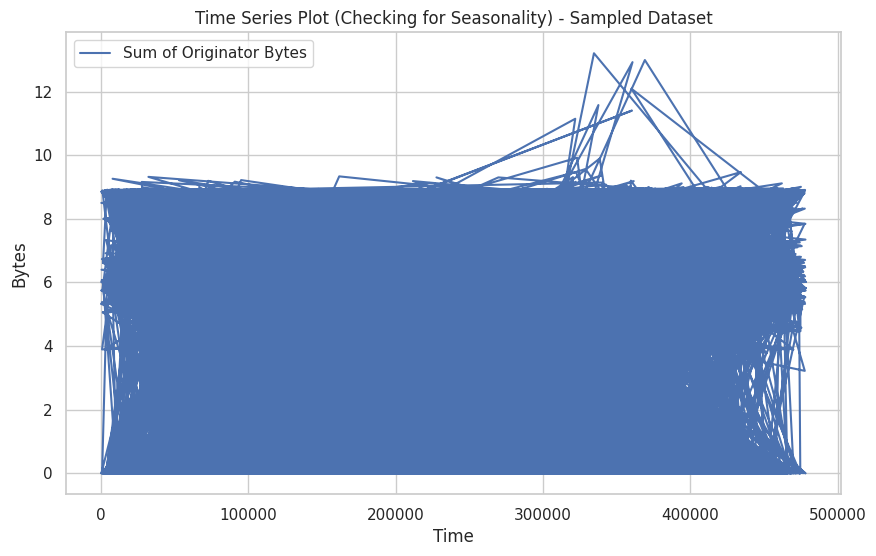

The sampled time series does not show significant evidence of seasonality.


<Figure size 1000x600 with 0 Axes>

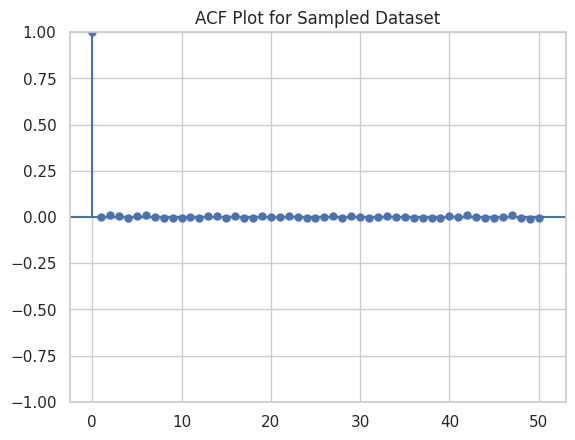

Seasonal periods detected: [None]
No seasonality detected. Fitting auto_arima without seasonality...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=155515.154, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=121477.129, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=140848.388, Time=0.55 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=115458.625, Time=0.25 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=112889.692, Time=0.53 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=111577.218, Time=0.71 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.85 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=9.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=7.25 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=10.59 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=106431.760, Time=2.59 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=106430.946, Time=2.35 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=106430.137, Time=0.83 sec

In [7]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Take dataset 8 (attack only data) and use it to train
df_train_sample = df_list[7]

# Check for Stationarity Using Augmented Dickey-Fuller (ADF) Test on the sampled data
result = adfuller(df_train_sample['sum_orig_bytes_log'].dropna())

# Extract and print test statistics
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values: ')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpret the result
if result[1] < 0.05:
    print(f"The time series for the sampled dataset is stationary (reject H0)")
else:
    print(f"The time series for the sampled dataset is non-stationary (fail to reject H0)")

# Check for seasonality and plot ACF for the sampled data
seasonal_list = []  # 1 for seasonal, 0 for non-seasonal
seasonal_periods = []  # Record the seasonal period (m)

# Plot the original time series for the sampled data
plt.figure(figsize=(10,6))
plt.plot(df_train_sample['sum_orig_bytes_log'], label='Sum of Originator Bytes')
plt.title('Time Series Plot (Checking for Seasonality) - Sampled Dataset')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.show()

# Calculate the maximum number of lags based on data length
max_lags = min(50, len(df_train_sample['sum_orig_bytes_log']) - 1)  # Ensure we don't exceed the data length
acf_values = acf(df_train_sample['sum_orig_bytes_log'], nlags=max_lags)

# Threshold for significance (1.96/sqrt(N), where N is the number of observations)
threshold = 1.96 / (len(df_train_sample['sum_orig_bytes_log']) ** 0.5)

# Identify significant lags
significant_lags = [lag for lag, value in enumerate(acf_values) if abs(value) > threshold]

# Determine if the dataset is seasonal
seasonal = False
seasonal_period = None

for j in range(1, len(significant_lags)):
    # Calculate the gap between significant lags
    lag_gap = significant_lags[j] - significant_lags[j-1]
    if lag_gap > 1:  # Avoid immediate autocorrelations
        seasonal = True
        seasonal_period = lag_gap
        break

# Record results for the sampled dataset
if seasonal:
    print(f"The sampled time series shows evidence of seasonality with a period of {seasonal_period}.")
    seasonal_list.append(1)
    seasonal_periods.append(seasonal_period)
else:
    print(f"The sampled time series does not show significant evidence of seasonality.")
    seasonal_list.append(0)
    seasonal_periods.append(None)  # No seasonality detected

# Plot the ACF for visual purposes
plt.figure(figsize=(10, 6))
plot_acf(df_train_sample['sum_orig_bytes_log'], lags=max_lags)
plt.title("ACF Plot for Sampled Dataset")
plt.show()

# Print the seasonal periods found for reference
print("Seasonal periods detected:", seasonal_periods)

# Define lists for p, d, q
p_list = []
d_list = []
q_list = []

# Check if the seasonal period is not None before fitting the ARIMA model
seasonal_period = seasonal_periods[0] if seasonal_list[0] == 1 else None

if seasonal_period is not None:
    print("Fitting auto_arima with seasonality...")

    try:
        # Fit auto_arima to find optimal p, d, q values based on seasonality
        auto_model = auto_arima(df_train_sample['sum_orig_bytes_log'],
                                start_p=0, max_p=14,  # Range for p
                                start_q=0, max_q=5,   # Range for q
                                d=None,                # Let auto_arima determine d
                                seasonal=True,         # Seasonality is detected
                                m=seasonal_period,     # Use the seasonal period found
                                trace=True,            # Output the process
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

        # Print the summary of the best model found
        print("Summary for Sampled Dataset:")
        print(auto_model.summary())

        # Get the best values of p, d, and q
        p, d, q = auto_model.order

        p_list.append(p)
        d_list.append(d)
        q_list.append(q)
    except Exception as e:
        print(f"An error occurred while fitting auto_arima for the sampled dataset: {e}")
else:
    print("No seasonality detected. Fitting auto_arima without seasonality...")

    try:
        # Fit auto_arima to find optimal p, d, q values for non-seasonal data
        auto_model = auto_arima(df_train_sample['sum_orig_bytes_log'],
                                start_p=0, max_p=14,  # Range for p
                                start_q=0, max_q=5,   # Range for q
                                d=None,                # Let auto_arima determine d
                                seasonal=False,        # No seasonality detected
                                trace=True,            # Output the process
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

        # Print the summary of the best model found
        print("Summary for Sampled Dataset:")
        print(auto_model.summary())

        # Get the best values of p, d, and q
        p, d, q = auto_model.order

        p_list.append(p)
        d_list.append(d)
        q_list.append(q)
    except Exception as e:
        print(f"An error occurred while fitting auto_arima for the sampled dataset: {e}")

# After training the ARIMA model, you can use the fitted model to make forecasts
try:
    model = auto_arima(df_train_sample['sum_orig_bytes_log'],
                       p=p_list[0], d=d_list[0], q=q_list[0],
                       seasonal=True if seasonal_list[0] == 1 else False,
                       m=seasonal_periods[0] if seasonal_list[0] == 1 else None,
                       trace=True, error_action='ignore', suppress_warnings=True)

    # Forecasting the next steps (adjust the forecast horizon as needed)
    forecast_steps = 10  # Example, forecast for 10 steps ahead
    forecast = model.predict(n_periods=forecast_steps)

    print(f"Forecast for Sampled Dataset:")
    print(forecast)
except Exception as e:
    print(f"An error occurred during forecasting for the sampled dataset: {e}")